# Face Detection Analysis

In [1]:
import cv2
import os
import helpers
import pickle
import numpy as np
import matplotlib.pyplot as plt
from od_metrics.BoundingBox import BoundingBox
from od_metrics.BoundingBoxes import BoundingBoxes
from od_metrics.utils import BBFormat, BBType
from od_metrics.Evaluator import Evaluator
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.get_logger().setLevel('ERROR')

use_pickle = True
pickle_path = '../kaggle_dataset_863/kaggle_863_alt.pkl'

## Dataset Analysis and Loading
This dataset has 853 images, mostly masked faces.

In [2]:
# load images and associated faces
# this takes a second since we load with cv2
if not use_pickle:
    imgs_with_labels = helpers.load_kaggle_863('../kaggle_dataset_863')
    imgs_with_labels = helpers.convert_kaggle_863_for_metrics(imgs_with_labels)
    with open(pickle_path, 'wb') as f:
        pickle.dump(imgs_with_labels, f)
else:
    with open(pickle_path, 'rb') as f:
        imgs_with_labels = pickle.load(f)

print(len(imgs_with_labels['raw_data']))

853


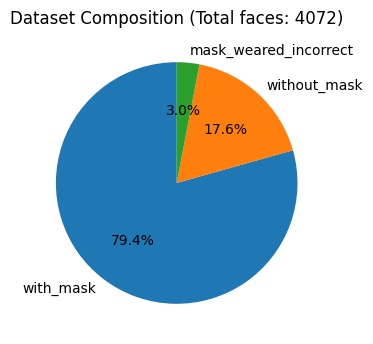

In [23]:
# determine dataset composition
composition = {'with_mask': 0, 'without_mask': 0, 'mask_weared_incorrect': 0}
for img in imgs_with_labels['raw_data'].values():
    for face in img['raw_annotation'].iter('object'):
        composition[face.find('name').text] += 1
        
plt.pie(composition.values(), labels=composition.keys(), autopct='%1.1f%%', startangle=90)
plt.gcf().set_dpi(100)
plt.savefig('./figures/kaggle_853_composition.png', dpi=300, transparent=True)
plt.show()

Max faces: 115
Average faces: 4.773739742086753


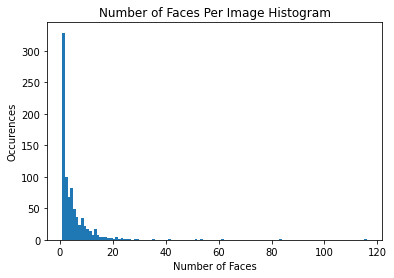

In [28]:
# plot histogram of # of faces per image
faces_per_img = []
for img_name in imgs_with_labels['raw_data'].keys():
    faces_per_img.append(len(imgs_with_labels['bboxes'].getBoundingBoxesByImageName(img_name)))
    
print('Max faces: ' + str(max(faces_per_img)))
print('Average faces: ' + str(sum(faces_per_img)/len(faces_per_img)))
    
plt.hist(faces_per_img, bins=range(1, max(faces_per_img)+2))
plt.title("Number of Faces Per Image Histogram")
plt.savefig('./figures/faces_per_img.png', dpi=300, transparent=True)
plt.xlabel('Number of Faces')
plt.ylabel('Occurences')
plt.show()

Average face dim: 44.47542698061543 px
Max dim: 326.8470590352619 px
Min dim: 1.4142135623730951 px


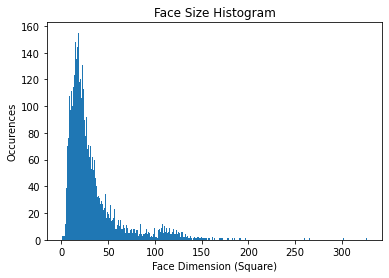

In [29]:
# determine average face size
face_sizes = []
max_size = 0
min_size = 10**3
for box in imgs_with_labels['bboxes'].getBoundingBoxes():
    (xmin, ymin, xmax, ymax) = box.getAbsoluteBoundingBox(format=BBFormat.XYX2Y2)
    size = (xmax-xmin) * (ymax-ymin)
    if size < min_size: min_size = size
    if size > max_size: max_size = size
    face_sizes.append(size)
        
average_face_dim = (sum(face_sizes)/len(face_sizes))**(1/2)
print('Average face dim: ' + str(average_face_dim) + " px")
print('Max dim: ' + str(max_size**(1/2)) + " px")
print('Min dim: ' + str(min_size**(1/2)) + " px")

dim = [i**(1/2) for i in face_sizes]

plt.hist(dim, bins=range(1, int(max(dim))+2))
plt.title("Face Size Histogram")
plt.savefig('./figures/face_size_hist.png', dpi=300, transparent=True)
plt.xlabel('Face Dimension (Square)')
plt.ylabel('Occurences')
plt.show()

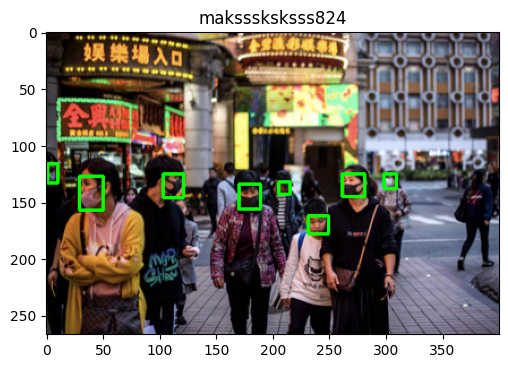

In [6]:
# display a sample
img_name, img_data = list(imgs_with_labels['raw_data'].items())[0]
img = np.copy(img_data['img'])
img = imgs_with_labels['bboxes'].drawAllBoundingBoxes(img, img_name)

img = helpers.to_rgb(img)

plt.imshow(img)
plt.gcf().set_dpi(100)
plt.title(img_name)
plt.show()

## Non-Deep Learning
Here we investigate Viola-Jones (Haar wavelet-based, in cv2) and HOG + Linear SVM (Histogram of Directed Gradient, in face_detection) approaches for face detection in images.

In [10]:
# eventually this will be populated with BoundingBoxes
haar_detection_results = {}

### CV2 Haar Testing

In [31]:
import time
times = []
for i in range(len(haar_cascade_paths)):
    haar_cascade = cv2.CascadeClassifier(haar_cascade_paths[i])
    img_name, img_data = list(imgs_with_labels['raw_data'].items())[0]
    img = img_data['img']
    gray_img = helpers.to_gray(img)
    a = time.time()
    faces = haar_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=2)
    b = time.time()
    times.append(b-a)

In [32]:
times

[0.03732013702392578,
 0.03167533874511719,
 0.022443056106567383,
 0.034537553787231445]

In [11]:
haar_cascade_names = [
    'frontalface_alt',
    'frontalface_alt2',
    'frontalface_alt_tree',
    'frontalface_default'
]
haar_cascade_paths = [cv2.data.haarcascades + 'haarcascade_' + n + '.xml'
                      for n in haar_cascade_names]
haar_results = {}
# clone ground bbox data to be populated by each haar detector
for name in haar_cascade_names:
    haar_detection_results[name] = imgs_with_labels['bboxes'].clone()

In [10]:
for i in range(len(haar_cascade_paths)):
    haar_cnt = 0
    cnt = 0
    haar_cascade = cv2.CascadeClassifier(haar_cascade_paths[i])
    detections = haar_detection_results[haar_cascade_names[i]]
    for img_name, img_data in imgs_with_labels['raw_data'].items():
        img = img_data['img']
        gray_img = helpers.to_gray(img)
        faces = haar_cascade.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=2)
        # detectMultiScale provides (x, y, w, h)
        # we can use this with BoundingBox also by changing format
        for (x, y, w, h) in faces:
            b = BoundingBox(
                imageName = img_name,
                classId = 'face',
                x = x,
                y = y,
                w = w,
                h = h,
                bbType = BBType.Detected,
                format = BBFormat.XYWH,
                classConfidence = 1
            )
            detections.addBoundingBox(b)
            
        # uncomment this block to display each image comparison  
#         disp_img = np.copy(img)

#         disp_img = detections.drawAllBoundingBoxes(disp_img, img_name)

#         cv2.imshow(img_name, disp_img)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

#         cnt += 1
#         if (cnt > 5): break
    
#     haar_cnt +=1
#     if (haar_cnt > 0):
#         break

In [11]:
# with open('haar_results.pkl', 'wb') as f:
#     pickle.dump(detection_results, f)

In [47]:
with open('haar_results.pkl', 'rb') as f:
    haar_detection_results = pickle.load(f)

In [48]:
evaluator = Evaluator()
metric_dict = {}
for t, result in haar_detection_results.items():
    metrics = evaluator.GetPascalVOCMetrics(haar_detection_results[t],
                                            IOUThreshold=0.3)
    total_pos = metrics[0]['total positives']
    tp = metrics[0]['total TP']
    fp = metrics[0]['total FP']
    metric_dict[t] = {
        'total positives': total_pos,
        'total TP': tp,
        'total FP': fp,
        'prec': helpers.compute_precision(tp, fp),
        'recall': helpers.compute_recall(tp, total_pos)
    }

In [49]:
metric_dict

{'frontalface_alt': {'total positives': 4072,
  'total TP': 772.0,
  'total FP': 90.0,
  'prec': 0.8955916473317865,
  'recall': 0.18958742632612965},
 'frontalface_alt2': {'total positives': 4072,
  'total TP': 851.0,
  'total FP': 148.0,
  'prec': 0.8518518518518519,
  'recall': 0.20898821218074656},
 'frontalface_alt_tree': {'total positives': 4072,
  'total TP': 117.0,
  'total FP': 1.0,
  'prec': 0.9915254237288136,
  'recall': 0.028732809430255402},
 'frontalface_default': {'total positives': 4072,
  'total TP': 750.0,
  'total FP': 417.0,
  'prec': 0.6426735218508998,
  'recall': 0.18418467583497053}}

In [10]:
# maybe make a bar graph of the prec/recall scores for these detectors

## Deep Learning
Now we look at MTCNN, RetinaFace, MMOD?

In [7]:
dl_detection_results = {}
# mtcnn implemented by TF
dl_detection_results['mtcnn'] = imgs_with_labels['bboxes'].clone()
# mtcnn implemented by PyTorch (fdet)
dl_detection_results['fdet_mtcnn'] = imgs_with_labels['bboxes'].clone()
# mobilenet backed retinaface from fdet
dl_detection_results['retinaface_mobilenet'] = imgs_with_labels['bboxes'].clone()
# resnet backed retinaface from fdet
dl_detection_results['retinaface_resnet50'] = imgs_with_labels['bboxes'].clone()
# mobilenet backed retinaface from retinaface package
dl_detection_results['retinaface_mobilenet_alt'] = imgs_with_labels['bboxes'].clone()
# resnet backed retinaface from retinaface_pytorch package
dl_detection_results['retinaface_resnet50_alt'] = imgs_with_labels['bboxes'].clone()

### TF MTCNN

In [11]:
from mtcnn import MTCNN

In [12]:
mtcnn_detector = MTCNN()
cnt = 0

detections = dl_detection_results['mtcnn']

for img_name, img_data in imgs_with_labels['raw_data'].items():
    img = img_data['img']
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = mtcnn_detector.detect_faces(rgb_img)
    
    for face in faces:
        (x, y, w, h) = face['box']
        b = BoundingBox(
            imageName = img_name,
            classId = 'face',
            x = x,
            y = y,
            w = w,
            h = h,
            bbType = BBType.Detected,
            format = BBFormat.XYWH,
            classConfidence = face['confidence']
        )
        detections.addBoundingBox(b)
        
    # uncomment this block to display each image comparison   
#     disp_img = np.copy(img)

#     disp_img = detections.drawAllBoundingBoxes(disp_img, img_name)

#     cv2.imshow(img_name, disp_img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

    cnt += 1
    if cnt%10 == 0: print(cnt)
#     if (cnt > 50): break

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850


In [13]:
# with open('mtcnn_results.pkl', 'wb') as f:
#     pickle.dump(dl_detection_results['mtcnn'], f)

In [23]:
with open('mtcnn_results.pkl', 'rb') as f:
    dl_detection_results['mtcnn'] = pickle.load(f)

In [36]:
evaluator = Evaluator()
mtcnn_metrics = evaluator.GetPascalVOCMetrics(dl_detection_results['mtcnn'],
                                              IOUThreshold=0.3)
total_pos = mtcnn_metrics[0]['total positives']
tp = mtcnn_metrics[0]['total TP']
fp = mtcnn_metrics[0]['total FP']
metric_dict_mtcnn = {
    'total positives': total_pos,
    'total TP': tp,
    'total FP': fp,
    'prec': helpers.compute_precision(tp, fp),
    'recall': helpers.compute_recall(tp, total_pos)
}

In [37]:
metric_dict_mtcnn

{'total positives': 4072,
 'total TP': 2466.0,
 'total FP': 155.0,
 'prec': 0.9408622663105685,
 'recall': 0.6055992141453831}

### PyTorch fdet MTCNN

In [26]:
from fdet import MTCNN as MTCNN_FDET

mtcnn_detector_fdet = MTCNN_FDET()
cnt = 0

detections = dl_detection_results['fdet_mtcnn']

for img_name, img_data in imgs_with_labels['raw_data'].items():
    img = img_data['img']
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = mtcnn_detector_fdet.detect(rgb_img)
    
    for face in faces:
        (x, y, w, h) = face['box']
        b = BoundingBox(
            imageName = img_name,
            classId = 'face',
            x = x,
            y = y,
            w = w,
            h = h,
            bbType = BBType.Detected,
            format = BBFormat.XYWH,
            classConfidence = face['confidence']
        )
        detections.addBoundingBox(b)
        
    # uncomment this block to display each image comparison   
#     disp_img = np.copy(img)

#     disp_img = detections.drawAllBoundingBoxes(disp_img, img_name)

#     cv2.imshow(img_name, disp_img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

    cnt += 1
    if cnt%10 == 0: print(cnt)
#     if (cnt > 10): break

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850


In [38]:
# with open('mtcnn_fdet_results.pkl', 'wb') as f:
#     pickle.dump(dl_detection_results['fdet_mtcnn'], f)

In [50]:
with open('mtcnn_fdet_results.pkl', 'rb') as f:
    dl_detection_results['fdet_mtcnn'] = pickle.load(f)

In [51]:
evaluator = Evaluator()
mtcnn_fdet_metrics = evaluator.GetPascalVOCMetrics(dl_detection_results['fdet_mtcnn'],
                                            IOUThreshold=0.3)
total_pos = mtcnn_fdet_metrics[0]['total positives']
tp = mtcnn_fdet_metrics[0]['total TP']
fp = mtcnn_fdet_metrics[0]['total FP']
metric_dict_mtcnn_fdet = {
    'total positives': total_pos,
    'total TP': tp,
    'total FP': fp,
    'prec': helpers.compute_precision(tp, fp),
    'recall': helpers.compute_recall(tp, total_pos)
}

In [52]:
metric_dict_mtcnn_fdet

{'total positives': 4072,
 'total TP': 2563.0,
 'total FP': 234.0,
 'prec': 0.9163389345727565,
 'recall': 0.6294204322200393}

### RetinaFace with MobileNet
from: https://github.com/heewinkim/retinaface  
TF 2.1

In [18]:
from retinaface import RetinaFace
import time

retinaface_detector = RetinaFace(quality='normal')
cnt = 0

dl_detection_results['retinaface_mobilenet_alt'] = imgs_with_labels['bboxes'].clone()
detections = dl_detection_results['retinaface_mobilenet_alt']

det_times = []

for img_name, img_data in imgs_with_labels['raw_data'].items():
    img = img_data['img']
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # using default threshold
    a = time.time()
    faces = retinaface_detector.predict(rgb_img.astype(np.float32), threshold=0.7)
    b = time.time()
    det_times.append(b-a)
    
    for face in faces:
#         (x, y, x2, y2) = face['box']
        b = BoundingBox(
            imageName = img_name,
            classId = 'face',
            x = face['x1'],
            y = face['y1'],
            w = face['x2'],
            h = face['y2'],
            bbType = BBType.Detected,
            format = BBFormat.XYX2Y2,
            classConfidence = 1
        )
        detections.addBoundingBox(b)
        
    # uncomment this block to display each image comparison   
#     disp_img = np.copy(img)

#     disp_img = detections.drawAllBoundingBoxes(disp_img, img_name)

#     cv2.imshow(img_name, disp_img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

    cnt += 1
    if cnt%10 == 0: print(cnt)
#     if (cnt > 10): break

model[normal quality] init ..
model success !
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850


In [19]:
# timing analysis
print(sum(det_times)/len(det_times))
print(max(det_times))

0.11461091572626254
0.20961999893188477


In [20]:
# with open('retinaface_mobilenet_results_70.pkl', 'wb') as f:
#     pickle.dump(dl_detection_results['retinaface_mobilenet_alt'], f)

In [30]:
with open('retinaface_mobilenet_results_70.pkl', 'rb') as f:
    dl_detection_results['retinaface_mobilenet_alt'] = pickle.load(f)

In [31]:
evaluator = Evaluator()
retinaface_mobilenet_alt_metrics = evaluator.GetPascalVOCMetrics(dl_detection_results['retinaface_mobilenet_alt'],
                                            IOUThreshold=0.3)
total_pos = retinaface_mobilenet_alt_metrics[0]['total positives']
tp = retinaface_mobilenet_alt_metrics[0]['total TP']
fp = retinaface_mobilenet_alt_metrics[0]['total FP']
metric_dict_retinaface_mobilenet_alt = {
    'total positives': total_pos,
    'total TP': tp,
    'total FP': fp,
    'prec': helpers.compute_precision(tp, fp),
    'recall': helpers.compute_recall(tp, total_pos)
}

In [32]:
metric_dict_retinaface_mobilenet_alt

{'total positives': 4072,
 'total TP': 3382.0,
 'total FP': 301.0,
 'prec': 0.9182731468911214,
 'recall': 0.8305500982318271}

### RetinaFace with ResNet 50
from: https://github.com/ternaus/retinaface  
PyTorch  
Turns out this one is HOPELESSLY SLOW with the resnet50 backbone!!  

**NOTE**: Must uninstall the "retinaface" package before using this, otherwise there is a namespace clash!

In [82]:
from retinaface.pre_trained_models import get_model

retinaface_detector_resnet_alt = get_model("resnet50_2020-07-20", max_size=2048)
# necessary but idk why
retinaface_detector_resnet_alt.eval()
cnt = 0

detections = dl_detection_results['retinaface_resnet50_alt']

for img_name, img_data in imgs_with_labels['raw_data'].items():
    img = img_data['img']
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # using default threshold
    faces = retinaface_detector_resnet_alt.predict_jsons(rgb_img.astype(np.float32))
    print(img_name)
    for face in faces:
        try:
            (x, y, x2, y2) = face['bbox']
        except Exception as e:
            # just ignore this one if it fails
            continue
        b = BoundingBox(
            imageName = img_name,
            classId = 'face',
            x = x,
            y = y,
            w = x2,
            h = y2,
            bbType = BBType.Detected,
            format = BBFormat.XYX2Y2,
            classConfidence = face['score']
        )
        detections.addBoundingBox(b)
        
    # uncomment this block to display each image comparison   
#     disp_img = np.copy(img)

#     disp_img = detections.drawAllBoundingBoxes(disp_img, img_name)

#     cv2.imshow(img_name, disp_img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

    cnt += 1
    if cnt%5 == 0: print(cnt)
#     if (cnt > 5): break

/home/carson/anaconda3/envs/mask/lib/python3.7/site-packages/torch/hub.py:483: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


maksssksksss824
maksssksksss90
maksssksksss206
maksssksksss747
maksssksksss823
5
maksssksksss795
maksssksksss265
maksssksksss794
maksssksksss567
maksssksksss762
10
maksssksksss172
maksssksksss603
maksssksksss839
maksssksksss659
maksssksksss439
15
maksssksksss738
maksssksksss126
maksssksksss478
maksssksksss596
maksssksksss554
20
maksssksksss814
maksssksksss686
maksssksksss370
maksssksksss530
maksssksksss62
25
maksssksksss391
maksssksksss203
maksssksksss613
maksssksksss309
maksssksksss281
30
maksssksksss579
maksssksksss500
maksssksksss621
maksssksksss698
maksssksksss384
35
maksssksksss305
maksssksksss607
maksssksksss758
maksssksksss310
maksssksksss183
40
maksssksksss641
maksssksksss563
maksssksksss47
maksssksksss705
maksssksksss492
45
maksssksksss551
maksssksksss12
maksssksksss274
maksssksksss335
maksssksksss810
50
maksssksksss662
maksssksksss462
maksssksksss171
maksssksksss819
maksssksksss190
55
maksssksksss52
maksssksksss831
maksssksksss343
maksssksksss435
maksssksksss266
60
maksssksks

maksssksksss354
maksssksksss558
495
maksssksksss164
maksssksksss393
maksssksksss181
maksssksksss532
maksssksksss143
500
maksssksksss425
maksssksksss628
maksssksksss442
maksssksksss98
maksssksksss646
505
maksssksksss79
maksssksksss367
maksssksksss411
maksssksksss625
maksssksksss236
510
maksssksksss793
maksssksksss642
maksssksksss352
maksssksksss132
maksssksksss363
515
maksssksksss470
maksssksksss459
maksssksksss514
maksssksksss174
maksssksksss710
520
maksssksksss209
maksssksksss414
maksssksksss715
maksssksksss828
maksssksksss570
525
maksssksksss505
maksssksksss6
maksssksksss271
maksssksksss348
maksssksksss609
530
maksssksksss488
maksssksksss359
maksssksksss138
maksssksksss99
maksssksksss426
535
maksssksksss57
maksssksksss33
maksssksksss527
maksssksksss581
maksssksksss574
540
maksssksksss428
maksssksksss324
maksssksksss303
maksssksksss111
maksssksksss599
545
maksssksksss227
maksssksksss130
maksssksksss817
maksssksksss709
maksssksksss440
550
maksssksksss670
maksssksksss189
maksssksksss283

In [83]:
with open('retinaface_resnet50_alt.pkl', 'wb') as f:
    pickle.dump(dl_detection_results['retinaface_resnet50_alt'], f)

In [84]:
evaluator = Evaluator()
retinaface_resnet50_alt_metrics = evaluator.GetPascalVOCMetrics(dl_detection_results['retinaface_resnet50_alt'],
                                            IOUThreshold=0.3)
total_pos = retinaface_resnet50_alt_metrics[0]['total positives']
tp = retinaface_resnet50_alt_metrics[0]['total TP']
fp = retinaface_resnet50_alt_metrics[0]['total FP']
metric_dict_retinaface_resnet50_alt = {
    'total positives': total_pos,
    'total TP': tp,
    'total FP': fp,
    'prec': helpers.compute_precision(tp, fp),
    'recall': helpers.compute_recall(tp, total_pos)
}

In [85]:
metric_dict_retinaface_resnet50_alt

{'total positives': 4072,
 'total TP': 3674.0,
 'total FP': 619.0,
 'prec': 0.8558117866293967,
 'recall': 0.9022593320235757}